In [55]:
# -*- coding: utf-8 -*-
###############################################################################

# This notebook implements the plots in the Chapter 5.1 of the paper.  
# https://arxiv.org/pdf/1007.1727v3.pdf

# Author: Haoran Zhao
# Email: hrzhao76 AT gmail.com
###############################################################################

In [56]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import hist
import mplhep
from typing import Union

mplhep.style.use(mplhep.style.ATLAS)

np.random.seed(42)

# Figure 3(a)

In [57]:
def Likelihood(
    n: Union[int, np.array],
    m: Union[int, np.array],
    b: int,
    mu: float,
    s: int = 10,
    tau: float = 1,
) -> Union[float, np.array]:
    """The Likelihood function for the Counting experiment, eqn 90. 

    Args:
        n (Union[int, np.array]): Observed number of events. 
        m (Union[int, np.array]): Control sample help to constrain the nuisance parameter b.
        b (int): Expected number from background processes.
        mu (float): Signal strength.
        s (int, optional): Expected number of signal events. Defaults to 10.
        tau (float, optional): Scale factor. Defaults to 1.

    Returns:
        Union[float, np.array]: The likelihood function.
    """
    poisson_sig = stats.poisson.pmf(mu=mu * s + b, k=n)
    poisson_bkg = stats.poisson.pmf(mu=tau * b, k=m)
    return poisson_sig * poisson_bkg


def MLE_mu_hat(
    n: Union[int, np.array],
    m: Union[int, np.array],
    s: int = 10,
    tau: float = 1,
) -> Union[float, np.array]:
    """Maximum likelihood estimator of mu, eqn 91.

    Args:
        n (Union[int, np.array]): Observed number of events.
        m (Union[int, np.array]): Control sample help to constrain the nuisance parameter b.
        s (int, optional): Expected number of signal events. Defaults to 10.
        tau (float, optional): Scale factor. Defaults to 1.

    Returns:
        Union[float, np.array]: The MLE of mu.
    """
    return (n - m / tau) / (s)

def MLE_b_hat(
    m: Union[int, np.array],
    tau: float = 1,
) -> Union[float, np.array]:
    """Maximum likelihood estimator of b, eqn 92.

    Args:
        m (Union[int, np.array]): _description_
        tau (float, optional): _description_. Defaults to 1.

    Returns:
        Union[float, np.array]: _description_
    """
    return m / tau


def MLE_b_hat_hat(
    n: Union[int, np.array],
    m: Union[int, np.array],
    mu: float,
    s: int,
    tau: float = 1,
) -> Union[float, np.array]:

    a = tau * (tau + 1)
    b = tau * (mu * s + tau * mu * s - m - n)
    c = -m * tau * mu * s

    return (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)


def Lambda_mu(
    n: Union[int, np.array], m: Union[int, np.array], mu: float, s: int, tau: float = 1
) -> Union[float, np.array]:
    profiled_likelihood = Likelihood(n=n, m=m, mu=mu, b=MLE_b_hat_hat(n, m, mu, s))
    unconditional_likelihood = Likelihood(n=n, m=m, mu=MLE_mu_hat(n, m), b=MLE_b_hat(m))
    return profiled_likelihood / unconditional_likelihood


def Get_q0(
    n: Union[int, np.array], m: Union[int, np.array], mu: float, s: int, tau: float = 1
):
    mu_hat = MLE_mu_hat(n=n, m=m, tau=tau)
    neg_index = mu_hat < 0

    lambda_mu = Lambda_mu(n=n, m=m, mu=mu, s=s)
    lambda_mu[neg_index] = 1
    q0 = -2 * np.log(lambda_mu)

    return q0

In [58]:
def f_q0(q0: Union[float, np.array]) -> Union[float, np.array]:
    """pdf of q0 given mu_prime=0, eqn 49.

    Args:
        q0 (Union[float, np.array]): Test statistic q0 for discovery. 

    Returns:
        Union[float, np.array]: pdf of q0.
    """
    return 1 / 2 * 1 / np.sqrt(2 * np.pi) * 1 / np.sqrt(q0) * np.exp(-q0 / 2)


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


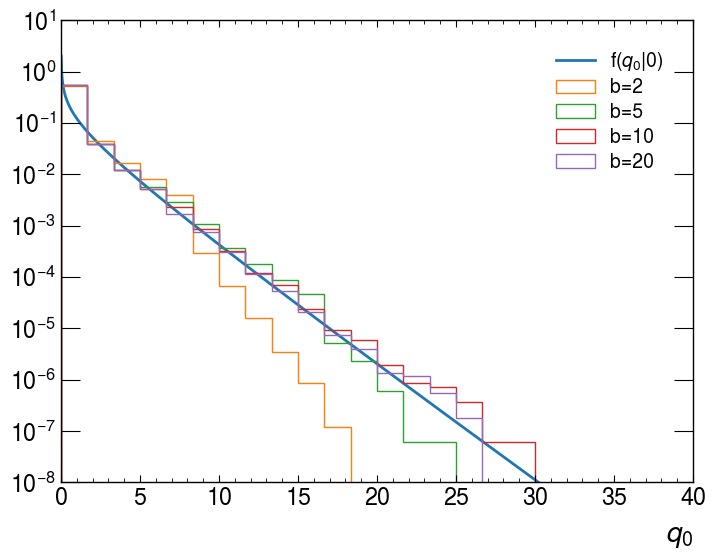

In [59]:
s = 10  # number of signal events
tau = 1 # scale factor, general unknown.

x_s = np.linspace(0.01, 40, 3001)

fig, ax = plt.subplots(figsize=(8, 6))
f_q0_x = f_q0(q0=x_s)
ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)
ax.set_yticks([10, 1] + [1 / 10**i for i in range(1, 9)])

ax.set_xlabel(r"$q_0$")


b_s = [2, 5, 10, 20]
mu = 0
N_trails = 10000000
for b in tqdm(b_s):
    n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
    m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)
    q0_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
    ax.hist(q0_s, bins=24, range=(0, 40), density=True, histtype="step", label=f"b={b}")

ax.legend()
plt.show()

# Figure 3(b)

In [77]:
def Get_qmu(
    n: Union[int, np.array], m: Union[int, np.array], mu: float, s: int, tau: float = 1
):
    mu_hat = MLE_mu_hat(n=n, m=m, tau=tau)
    greater_index = mu_hat > mu

    lambda_mu = Lambda_mu(n=n, m=m, mu=mu, s=s)
    lambda_mu[greater_index] = 1
    q0 = -2 * np.log(lambda_mu)

    return q0

In [66]:
def calSigma(mu_prime, s, b, mu):
    Likelihood_A = Lambda_mu(n=mu_prime * s + b, m=b, mu=mu, s=s)
    q_mu_A = -2 * np.log(Likelihood_A)
    sigma = 1.0 / np.sqrt(q_mu_A)

    return sigma

In [67]:
calSigma(mu_prime=1, s=10, b=10, mu=0)

0.5424872603903438

In [13]:
def f_q0_muprime(q0: Union[float, np.array], mu_prime: float, sigma: float) -> Union[float, np.array]:
    """pdf of q0 given mu_prime, eqn 48.

    Args:
        q0 (Union[float, np.array]): Test statistic q0 for discovery. 
        mu_prime (float): The signal strength.

    Returns:
        Union[float, np.array]: pdf of q0.
    """
    return 1 / 2 * 1 / np.sqrt(2 * np.pi) * 1 / np.sqrt(q0) * np.exp(-0.5 * np.power(np.sqrt(q0) - mu_prime / sigma, 2))

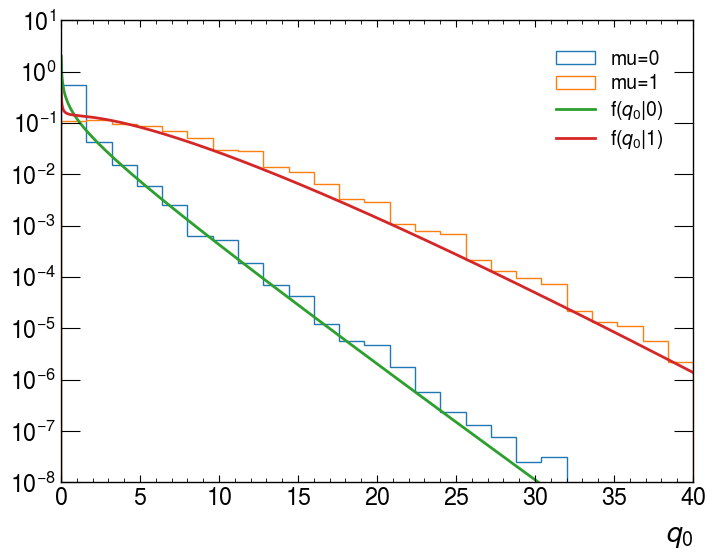

In [81]:
s = 10
b = 10
tau = 1
N_trails = 100000000

fig, ax = plt.subplots(figsize=(8, 6))
mu = 0
n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)

q0_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
ax.hist(q0_s, bins=25, range=(0, 40), density=True, histtype="step", label=f"mu=0")

q0_1_s = Get_qmu(n=n_s, m=m_s, mu=1, s=s)
ax.hist(q0_1_s, bins=25, range=(0, 40), density=True, histtype="step", label=f"mu=1")


x_s = np.linspace(0.01, 40, 3001)

f_q0_x = f_q0(q0=x_s)
f_q0_muprime_x = f_q0_muprime(q0=x_s, mu_prime=1, sigma=calSigma(mu_prime=1, s=10, b=10, mu=0))

ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.plot(x_s, f_q0_muprime_x, label=r"f($q_0$|1)")

ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)
ax.set_yticks([10, 1] + [1 / 10**i for i in range(1, 9)])

ax.set_xlabel(r"$q_0$")
plt.show()

# DeV 

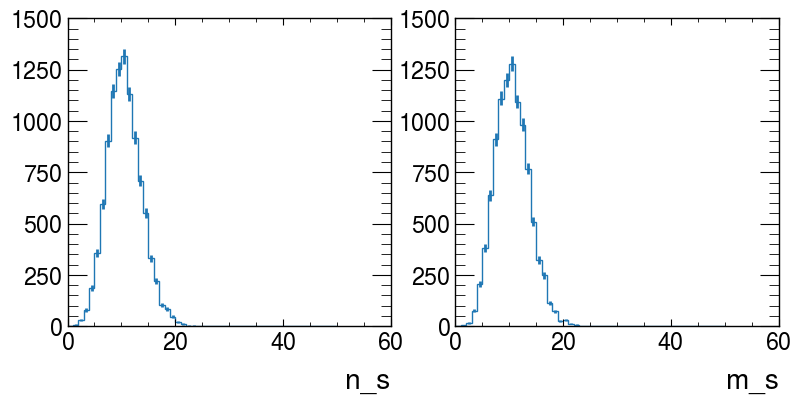

In [13]:
# N_trails = 100000000
N_trails = 10000
mu = 0
s = 10
b = 10
tau = 1

n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)

n_bins = 50
hist_2d = hist.Hist(
    hist.axis.Regular(n_bins, 0, n_bins, name="n_s"),
    hist.axis.Regular(n_bins, 0, n_bins, name="m_s"),
)

hist_2d.fill(n_s, m_s)


fig, axs = plt.subplots(1, 2, figsize=(9, 4))
mplhep.histplot(hist_2d.project("n_s"), label="n_s", ax=axs[0])
mplhep.histplot(hist_2d.project("m_s"), label="m_s", ax=axs[1])
plt.show()

In [ ]:
# WIP: the other approach  to calculate the sigma, eqn 18. 
def secondDerivativeMu(n, s, b, mu):
    denominator = n * np.power(s, 2)
    numerator = np.power(mu * s + b, 2) 
    return -1 * numerator / denominator

def secondDerivativeB(n, m, s, b, mu):
    first_term = m / np.power(b, 2)
    second_term = n / np.power(mu * s + b, 2)
    return -1 * (first_term + second_term)

def mixedSecondDerivativeMuB(n, s, b, mu):
    denominator = n * s
    numerator = np.power(mu * s + b, 2) 
    return -1 * numerator / denominator

def calSigma(s, b, tau, mu, N_trails=10000000):
    n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
    m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)

    V_inv_00 = -np.mean(secondDerivativeMu(n=n_s, s=s, b=b, mu=mu))
    V_inv_11 = -np.mean(secondDerivativeB(n=n_s, m=m_s, s=s, b=b, mu=mu))
    V_inv_01 = -np.mean(mixedSecondDerivativeMuB(n=n_s, s=s, b=b, mu=mu))
    V_inv_10 = V_inv_01

    V_inv = np.array([[V_inv_00, V_inv_01], [V_inv_10, V_inv_11]])
    V = np.linalg.inv(V_inv)

    sigma_mu = np.sqrt(V[0, 0])
    return sigma_mu

V_inv_00 = -np.mean(secondDerivativeMu(n=n_s, s=10, b=10, mu=1))
V_inv_11 = -np.mean(secondDerivativeB(n=n_s, m=m_s, s=10, b=10, mu=1))
V_inv_01 = -np.mean(mixedSecondDerivativeMuB(n=n_s, s=10, b=10, mu=1))
V_inv_10 = V_inv_01

V_inv = np.array([[V_inv_00, V_inv_01], [V_inv_10, V_inv_11]])
V = np.linalg.inv(V_inv)